In [2]:
!pip install tikzplotlib

<AxesSubplot:>

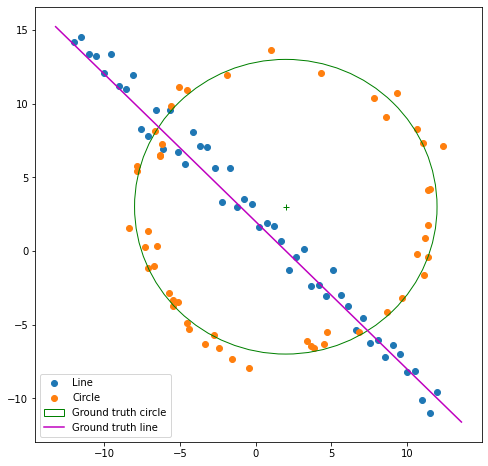

In [11]:
# Generating noisy point set

from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib

# Set random seed
np.random.seed(0)

# Constants
N = 100
half_n = N // 2

# Parameters
r = 10
x0_gt, y0_gt = 2, 3
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s, m, b = 1, -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

# Plotting
def plot_all(separate = True):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if separate:
        ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
        ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
    else:
        ax.scatter(X[:, 0], X[:, 1], label='Point Set')

    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, '+', color='g')

    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = m * x_ + b
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    return ax

plot_all()

Iteration 0: Number of inliers = 45
[0.72107214 0.69286    1.50978867] 12.08524521004736
Iteration 1: Number of inliers = 9
Iteration 2: Number of inliers = 8
Iteration 3: Number of inliers = 29
Iteration 4: Number of inliers = 16
Iteration 5: Number of inliers = 15
Iteration 6: Number of inliers = 31
Iteration 7: Number of inliers = 30
Iteration 8: Number of inliers = 42
[0.71149535 0.7026908  1.32487737] 10.299561498230432
Iteration 9: Number of inliers = 34
Iteration 10: Number of inliers = 6
Iteration 11: Number of inliers = 34
Iteration 12: Number of inliers = 9
Iteration 13: Number of inliers = 13
Iteration 14: Number of inliers = 9
Iteration 15: Number of inliers = 7
Iteration 16: Number of inliers = 11
Iteration 17: Number of inliers = 13
Iteration 18: Number of inliers = 11
Iteration 19: Number of inliers = 11
Iteration 20: Number of inliers = 12
Iteration 21: Number of inliers = 8
Iteration 22: Number of inliers = 34
Iteration 23: Number of inliers = 19
Iteration 24: Number o

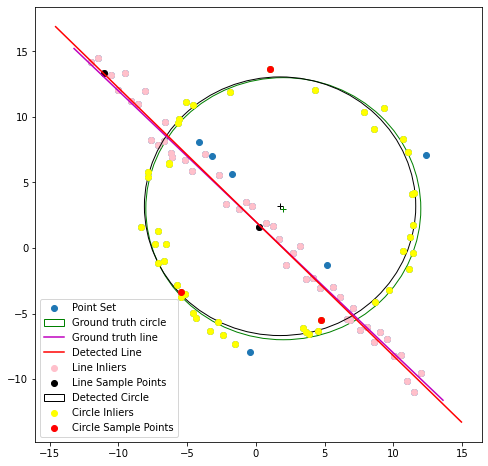

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Distance between two points
def calculate_distance(pt1, pt2):
    (x1, y1), (x2, y2) = pt1, pt2
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Line equation parameters: ax + by = d
def line_parameters(pt1, pt2):
    (x1, y1), (x2, y2) = pt1, pt2
    a = (y2 - y1)
    b = -(x2 - x1)
    d = a * x1 + b * y1
    assert np.abs(a * x2 + b * y2 - d) < 1e-8

    norm_factor = np.sqrt(a**2 + b**2)
    a, b, d = a / norm_factor, b / norm_factor, d / norm_factor
    return a, b, d

# Circle equation fitting using three points
def fit_circle(pt1, pt2, pt3):
    (x1, y1), (x2, y2), (x3, y3) = pt1, pt2, pt3
    
    # Midpoints and slopes of perpendicular bisectors
    midpoint1 = ((x1 + x2) / 2, (y1 + y2) / 2)
    midpoint2 = ((x1 + x3) / 2, (y1 + y3) / 2)
    
    slope1 = -(x2 - x1) / (y2 - y1)
    slope2 = -(x3 - x1) / (y3 - y1)
    
    # Solve for the center (cx, cy) of the circle
    c1 = midpoint1[1] - slope1 * midpoint1[0]
    c2 = midpoint2[1] - slope2 * midpoint2[0]
    
    cx = (c2 - c1) / (slope1 - slope2)
    cy = slope1 * cx + c1
    assert np.abs(slope2 * cx + c2 - cy) < 1e-8

    radius = calculate_distance((cx, cy), pt1)
    assert np.abs(calculate_distance((cx, cy), pt2) - radius) < 1e-8
    return cx, cy, radius

# Line fit error calculation
def line_fit_error(params, *args):
    a, b, d = params
    indices, points = args
    error = np.sum((a * points[indices, 0] + b * points[indices, 1] - d) ** 2)
    return error

# Circle fit error calculation
def circle_fit_error(params, *args):
    cx, cy, r = params
    indices, points = args
    error = np.sum((calculate_distance((cx, cy), (points[indices, 0], points[indices, 1])) - r) ** 2)
    return error

# Check if points fit the line
def check_line_consensus(params, threshold, points):
    a, b, d = params
    distances = np.abs(a * points[:, 0] + b * points[:, 1] - d)
    return np.where(distances < threshold)

# Check if points fit the circle
def check_circle_consensus(params, threshold, points):
    cx, cy, r = params
    radial_errors = np.abs(calculate_distance((cx, cy), (points[:, 0], points[:, 1])) - r)
    return np.where(radial_errors < threshold)

# Constraint to normalize line parameters
def normalize_params(params):
    a, b, _ = params
    return np.sqrt(a ** 2 + b ** 2) - 1

# Constraints dictionary
constraints = {'type': 'eq', 'fun': normalize_params}

# Optimize line fit using least squares
def optimize_line_fit(indices, initial_params, points):
    result = minimize(fun=line_fit_error, x0=initial_params, args=(indices, points), constraints=constraints, tol=1e-6)
    print(result.x, result.fun)
    return result

# Optimize circle fit using least squares
def optimize_circle_fit(indices, initial_params, points):
    result = minimize(fun=circle_fit_error, x0=initial_params, args=(indices, points), tol=1e-6)
    print(result.x, result.fun)
    return result

# RANSAC-like algorithm for line fitting
max_iterations = 100
min_sample_points = 2
num_points = X.shape[0]
np.random.seed(42)

threshold = 1.0
min_inliers = 0.4 * num_points

best_line_model = None
best_line_fit = None
min_error = np.inf
best_line_inliers = None
best_line_sample_points = None

for i in range(max_iterations):
    sample_indices = np.random.choice(np.arange(0, num_points), size=min_sample_points, replace=False)
    initial_params = line_parameters(X[sample_indices[0]], X[sample_indices[1]])
    inliers = check_line_consensus(initial_params, threshold, X)[0]
    print(f'Iteration {i}: Number of inliers = {len(inliers)}')

    if len(inliers) >= min_inliers:
        result = optimize_line_fit(inliers, initial_params, X)
        if result.fun < min_error:
            min_error = result.fun
            best_line_model = initial_params
            best_line_fit = result.x
            best_line_inliers = inliers
            best_line_sample_points = sample_indices

# Inliers for the final line
final_line_inliers = check_line_consensus(best_line_fit, 1.2, X)[0]

print(f'Best line = {best_line_fit}, Number of inliers = {len(final_line_inliers)}, Error = {min_error}')

# Circle fitting for the remaining points
remaining_indices = np.array([i for i in range(num_points) if i not in final_line_inliers])
remaining_points = X[remaining_indices]

max_iterations = 100
min_circle_points = 3

threshold = 1.2
min_inliers = 0.4 * num_points

best_circle_model = None
best_circle_fit = None
min_error = np.inf
best_circle_inliers = None
best_circle_sample_points = None

for i in range(max_iterations):
    sample_indices = np.random.choice(np.arange(len(remaining_points)), size=min_circle_points, replace=False)
    initial_circle_params = fit_circle(*remaining_points[sample_indices])
    inliers = check_circle_consensus(initial_circle_params, threshold, remaining_points)[0]
    print(f'Iteration {i}: Number of inliers = {len(inliers)}')

    if len(inliers) >= min_inliers:
        result = optimize_circle_fit(inliers, initial_circle_params, remaining_points)
        if result.fun < min_error:
            min_error = result.fun
            best_circle_model = initial_circle_params
            best_circle_fit = result.x
            best_circle_inliers = inliers
            best_circle_sample_points = sample_indices

# Inliers for the final circle
final_circle_inliers = check_circle_consensus(best_circle_fit, threshold, remaining_points)[0]

print(f'Best circle = {best_circle_fit}, Number of inliers = {len(final_circle_inliers)}, Error = {min_error}')

# Plotting results
ax = plot_all(False)

x_limits = ax.get_xlim()
x_vals = np.array([x_limits[0], x_limits[1]])
A, B, D = best_line_fit
line_indices = final_line_inliers

y_vals = (D - A * x_vals) / B
plt.plot(x_vals, y_vals, color='r', label='Detected Line')
ax.scatter(X[line_indices, 0], X[line_indices, 1], color='pink', label='Line Inliers')
ax.scatter(X[best_line_sample_points, 0], X[best_line_sample_points, 1], color='black', label='Line Sample Points')

cx, cy, r = best_circle_fit
circle_plot = plt.Circle((cx, cy), r, color='black', fill=False, label='Detected Circle')
ax.add_patch(circle_plot)
ax.plot(cx, cy, '+', color='black')

ax.scatter(remaining_points[final_circle_inliers, 0], remaining_points[final_circle_inliers, 1], color='yellow', label='Circle Inliers')
ax.scatter(remaining_points[best_circle_sample_points, 0], remaining_points[best_circle_sample_points, 1], color='red', label='Circle Sample Points')

plt.legend()